In [1]:
import pandas as pd
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
sys.path.append('../../')

from scoring.event_detection_matrix import competition_score
from tqdm import tqdm

## Daten laden

In [2]:
predictions = pd.read_parquet('./data/predicted_series.parquet')
validation_events = pd.read_csv('../../data/processed/validation_events_split.csv')

In [3]:
predictions['series_id'] = predictions['num_series_id']

In [4]:
predictions.dtypes

step                         int64
num_series_id                int64
awake                        int64
prediction_class             int64
prediction_confidence_0    float64
prediction_confidence_1    float64
series_id                    int64
dtype: object

In [5]:
predictions['correct_prediction'] = (predictions['awake'] == predictions['prediction_class']).replace({True: 1, False: 0})

## Event Extraction

In [6]:
def get_events_smoothed(test_series) :
    series_ids = test_series['num_series_id'].unique()
    events = []

    for idx in tqdm(series_ids):
        # Collecting sample and normalizing features
        X = test_series[test_series.num_series_id == idx]
                
        smoothing_length = 12 * 30 # 30 Minutes
        # We average the confidence, that the participant is awake
        X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
        X["asleep"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()

        # Binarize the asleep column
        X["asleep"] = X["asleep"].round()

        # Getting predicted onset and wakeup time steps
        pred_onsets = X[X['asleep'].diff() > 0]['step'].tolist() # diff is > 0 if it changes from 0 (awake) to 1 (asleep)
        pred_wakeups = X[X['asleep'].diff() < 0]['step'].tolist() # diff is < 0 if it changes from 1 (asleep) to 0 (awake)
     
        if len(pred_onsets) > 0:

            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets):
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups):
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods:
                # We take the score
                score = 1 - X[(X['step'] >= onset) & (X['step'] < wakeup)]['confidence_awake'].mean()

                # Adding sleep event to dataframe
                onset_row = {'row_id': len(events), 'series_id': idx, 'step': onset, 'event': 'onset', 'score': score}                
                events.append(onset_row)

                wakeup_row = {'row_id': len(events), 'series_id': idx, 'step': wakeup, 'event': 'wakeup', 'score': score}
                events.append(wakeup_row)

    return pd.DataFrame(events)

In [7]:
predicted_events = get_events_smoothed(predictions)

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_co

C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\

C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\

 33%|███████████████████████████▎                                                      | 18/54 [00:01<00:03, 10.65it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_co

 46%|█████████████████████████████████████▉                                            | 25/54 [00:02<00:02,  9.85it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_co

 57%|███████████████████████████████████████████████                                   | 31/54 [00:03<00:02,  9.06it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_co

 69%|████████████████████████████████████████████████████████▏                         | 37/54 [00:03<00:01, 10.50it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_co

 80%|█████████████████████████████████████████████████████████████████▎                | 43/54 [00:04<00:01,  9.74it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_co

 93%|███████████████████████████████████████████████████████████████████████████▉      | 50/54 [00:05<00:00,  9.16it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16184\2987299727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_co

In [8]:
sample = predictions[predictions.num_series_id == 123]

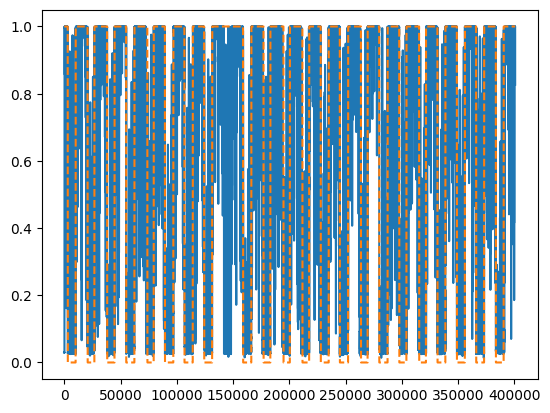

In [9]:
plt.plot(sample['step'], sample['prediction_confidence_1'])
plt.plot(sample['step'], sample['awake'], linestyle='dashed')
plt.show()

## Accuracy pro Serie

In [10]:
series = predictions.series_id.unique()

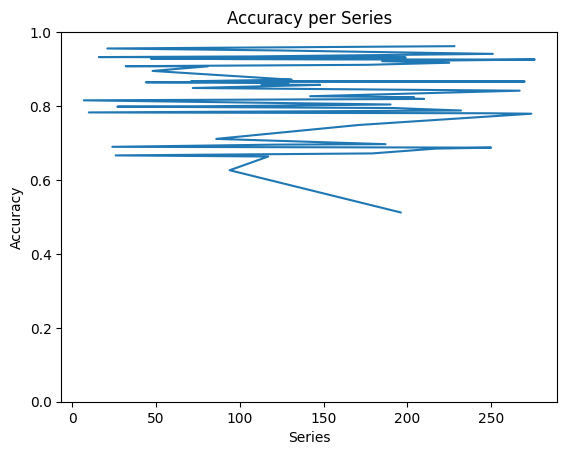

In [47]:
ax = predictions.groupby('series_id')['correct_prediction'].mean().sort_values().plot(
    ylim=(0, 1), title='Accuracy per Series'
)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Series")

fig = ax.get_figure()
fig.savefig("accuracy-per-series.png", bbox_inches="tight")

## Competition Score pro Serie

In [16]:
validation_events['series_id'] = validation_events['num_series_id']

In [17]:
predicted_events.series_id

0         7
1         7
2         7
3         7
4         7
       ... 
4043    276
4044    276
4045    276
4046    276
4047    276
Name: series_id, Length: 4048, dtype: int64

In [18]:
series_ids = predicted_events.series_id.unique()
scores = []

for series_id in tqdm(series_ids):
    predicted_events_series = predicted_events[predicted_events.series_id == series_id]
    true_events_series = validation_events[validation_events.series_id == series_id]

    score = competition_score(true_events_series, predicted_events_series)
    
    scores.append({'series_id': str(series_id), 'score': score})

scores = pd.DataFrame(scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.45it/s]


In [19]:
scores = scores.sort_values('score')

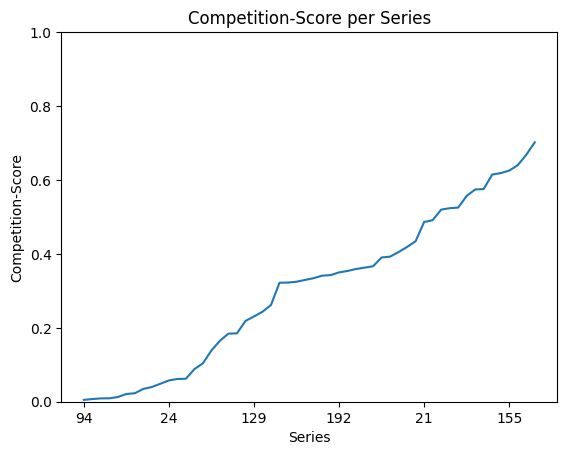

In [46]:
ax = scores.groupby('series_id')['score'].mean().sort_values().plot(
    ylim=(0, 1), title='Competition-Score per Series'
)
ax.set_ylabel("Competition-Score")
ax.set_xlabel("Series")
#ax.set_xticks(ticks=[*range(1, len(series), 2)], labels=series[::2], rotation=90)

fig = ax.get_figure()
fig.savefig("comp-score-per-series.png", bbox_inches="tight")

## Daten visualisieren

In [26]:
participant_series_id = 123
participant_series = predictions[predictions.series_id == participant_series_id]
participant_series = participant_series[0:100_000]

participant_events = predicted_events[predicted_events.series_id == participant_series_id]
participant_events = participant_events[0:12]

participant_true_events = validation_events[validation_events.series_id == participant_series_id]
participant_true_events = participant_true_events[0:12]

In [27]:
participant_series

step  num_series_id  awake  prediction_class  \
8954640      0            123      1                 0   
8954641      1            123      1                 0   
8954642      2            123      1                 0   
8954643      3            123      1                 0   
8954644      4            123      1                 0   
...        ...            ...    ...               ...   
9054635  99995            123      1                 1   
9054636  99996            123      1                 1   
9054637  99997            123      1                 1   
9054638  99998            123      1                 1   
9054639  99999            123      1                 1   

         prediction_confidence_0  prediction_confidence_1  series_id  \
8954640                 0.970221                 0.029779        123   
8954641                 0.970152                 0.029847        123   
8954642                 0.970168                 0.029832        123   
8954643                 0.970222                 0.029778        123   
8954644                 0.970255                 0.029745        123   
...                          ...                      ...        ...   
9054635                 0.001204                 0.998796        123   
9054636                 0.001435                 0.998565        123   
9054637                 0.001306                 0.998694        123   
9054638                 0.001557                 0.998443        123   
9054639                 0.002096                 0.997904        123   

         correct_prediction  
8954640                   0  
8954641                   0  
8954642                   0  
8954643                   0  
8954644                   0  
...                     ...  
9054635                   1  
9054636                   1  
9054637                   1  
9054638                   1  
9054639                   1  

[100000 rows x 8 columns]

In [28]:
participant_true_events

series_id  night   event     step                 timestamp  \
1206        123      1   onset   3060.0  2017-09-21T20:45:00-0400   
1207        123      1  wakeup  10080.0  2017-09-22T06:30:00-0400   
1208        123      2   onset  20700.0  2017-09-22T21:15:00-0400   
1209        123      2  wakeup  26736.0  2017-09-23T05:38:00-0400   
1210        123      3   onset  38064.0  2017-09-23T21:22:00-0400   
1211        123      3  wakeup  44628.0  2017-09-24T06:29:00-0400   
1212        123      4   onset  54984.0  2017-09-24T20:52:00-0400   
1213        123      4  wakeup  62304.0  2017-09-25T07:02:00-0400   
1214        123      5   onset  73800.0  2017-09-25T23:00:00-0400   
1215        123      5  wakeup  79452.0  2017-09-26T06:51:00-0400   
1216        123      6   onset  89412.0  2017-09-26T20:41:00-0400   
1217        123      6  wakeup  96876.0  2017-09-27T07:03:00-0400   

      num_series_id  
1206            123  
1207            123  
1208            123  
1209            123  
1210            123  
1211            123  
1212            123  
1213            123  
1214            123  
1215            123  
1216            123  
1217            123

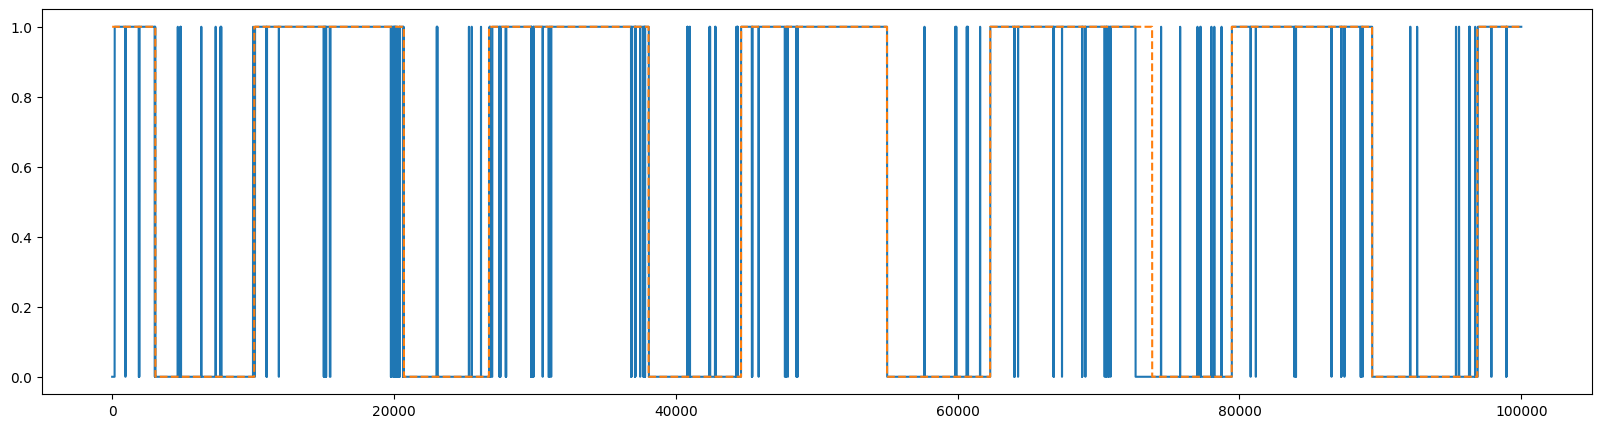

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(participant_series['step'], participant_series['prediction_class'])
plt.plot(participant_series['step'], participant_series['awake'], linestyle='dashed')
plt.show()

In [30]:
fig = px.line(participant_series, x='step', y='prediction_confidence_1', title=f'Schlafdaten für {participant_series_id}')
for index, row in participant_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_dash='dash', line_color=color)
    
for index, row in participant_true_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_color=color)

#Custom Legend
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='orange', width=2, dash='dash'),
        name="onset event",
    )
)
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='red', width=2, dash='dash'),
        name="wakeup event",
    )
)
fig.update_layout(legend_title="Events")
    
fig.show()